# We create the initial population to be used in the simulation

As always, we start with some imports

In [1]:
import pykep as pk
import numpy as np
import json
import pickle as pkl
from scipy.optimize import root

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import sgp4
from sgp4.api import Satrec, SatrecArray
%matplotlib inline

# We import the dataset containing the info on the tracked population
The files needed are:
* satcat_2023.txt (from https://celestrak.com/satcat/search.php) - This contains, for some, the RCS in meters.
* satcat_2023.json (from https://www.space-track.org/basicspacedata/query/class/gp/decay_date/null-val/epoch/%3Enow-30/orderby/norad_cat_id/format/json) -This has all information, but the RCS that only carries three levels small, medium big.


In [3]:
# Import the "old" SATCAT
satcat_old = pk.util.read_satcat("../data/satcat_2023.txt")
# Import the json catalogue
with open("../data/satcat_2023.json", "r") as file:
    satcat = json.load(file)
print("Satellites number in json: ", len(satcat))
print("Satellites number in txt: ", len(satcat_old))
to_satcat_index = np.arange(len(satcat))
print("Number of satellites left in the simulation: ", len(to_satcat_index))

Satellites number in json:  25600
Satellites number in txt:  57758
Number of satellites left in the simulation:  25600


The txt (SATCAT) contains more entries as all past decayed objects are also present, while in the json we only hve the currently orbiting ones

In [4]:
# Lets build the various orbiting objects from the TLEs
debris = []
for entry in satcat:
    try:
        line1 = entry["TLE_LINE1"]
        line2 = entry["TLE_LINE2"]
        debris.append(pk.planet.tle(line1, line2))
    except RuntimeError:
        # The alpha-5 format (https://www.space-track.org/documentation#tle-alpha5) is accounted for (ignored)
        # here. 
        line1 = list(line1)
        line1[2] = '0'
        line1 = ''.join(line1)
        line2 = list(line2)
        line2[2] = '0'
        line2 = ''.join(line2)
        debris.append(pk.planet.tle(line1, line2))

print("Satellites number with valid TLEs:", len(debris))

Satellites number with valid TLEs: 25600


Here the code is checking wheter the SATCAT.json catalogue has valid TLEs or not

In [5]:
# For each debris we retrieve and monkey patch the planet class with its collision radius
count = 0
for deb, deb_data in zip(debris, satcat):
    key = deb.name.strip()
    if key in satcat_old and satcat_old[key].radarA.strip() != "N/A":
        radius = np.sqrt(float(satcat_old[key].radarA)/np.pi)
        count += 1
    else:
        if deb_data["RCS_SIZE"] == "SMALL":
            radius = 0.15
        elif deb_data["RCS_SIZE"] == "MEDIUM":
            radius = 0.55
        else:
            radius = 2.
    deb.collision_radius = radius

print("Number of objects with radius estimated from satcat_old: ", count)
print("Number of objects with radius estimated from satcat: ", len(satcat) - count)

Number of objects with radius estimated from satcat_old:  14753
Number of objects with radius estimated from satcat:  10847


The code is computing the RCS: if the .txt file has its own RCS already defined, the code leave that, otherwise it takes it from the .json, where they are defined as small, medium or big.

In [6]:
# We create the initial state for all satellites that are not decayed and filtered
r = []
v = []
smal = []
el = []
incl = []
collision_radiusl= [] #COLLISION RADIUS! change name
to_satcat_index = []
n_decayed = 0
mask = 0
# t0 = pk.epoch_from_iso_string("20220301T000000")
t0 = pk.epoch_from_iso_string("20231130T000000")
for j, deb in enumerate(debris):
    try:
        rr, vv = deb.eph(t0)
        sma,e,inc,Om,om,nu = pk.ic2par(rr, vv, mu=pk.MU_EARTH)
        # if 4.2e7 <= sma <= 4.23e7 : # GEO
        # if sma < 1e7 : #LEO
        if np.deg2rad(97.6) <= inc <= np.deg2rad(97.7) and 6.9e6 <= sma <= 6.96e6: # SSO
            r.append(rr)
            v.append(vv)
            collision_radiusl.append(deb.collision_radius)
            smal.append(sma/1000)
            el.append(e)
            incl.append(inc*pk.RAD2DEG)
            to_satcat_index.append(j)
        else:
            mask += 1
    except:
        n_decayed+=1
r = np.array(r) # OSS: in m
v = np.array(v) # OSS: in m/s
reentry_radiusl = np.array(collision_radiusl)
smal = np.array(smal)
el = np.array(el)
incl = np.array(incl)
to_satcat_index = np.array(to_satcat_index)
print("Number of satellites decayed: ", n_decayed)
print("Number of objects removed: ", mask)
print("Number of satellites in the simulation: ", len(to_satcat_index))
print("Checking the sum of the three: ", mask + n_decayed + len(to_satcat_index))

Number of satellites decayed:  330
Number of objects removed:  24946
Number of satellites in the simulation:  324
Checking the sum of the three:  25600


In [7]:
# Here we find all unique elements in r
new_r, idx, count = np.unique(r[:,0], return_index=True, return_counts=True)
# We then ask where more than one element occur
where = np.where(count>2)[0]
# And for each entry that was not unique we retreive what objects
not_unique_lists = []
for not_unique in where:
    not_unique_lists.append(np.where(r[:,0] == r[idx[not_unique],0])[0])
# We now print on screen our findings
for not_unique in not_unique_lists:
    print("\nFound the following co-orbiting objects:")
    for idx in not_unique:
        print(satcat[to_satcat_index[idx]]["OBJECT_NAME"], "\t\twith RCS: ", debris[to_satcat_index[idx]].collision_radius)

In [8]:
# We find all indexes of entries that are not unique and (but we keep the biggest)
to_delete = []
for not_unique in not_unique_lists:
    to_delete.extend(sorted(not_unique, key = lambda idx: debris[to_satcat_index[idx]].collision_radius, reverse=True)[1:])
    
# And now we can remove and delete
r = np.delete(r, to_delete, axis=0)
v = np.delete(v, to_delete, axis=0)
collision_radiusl = np.delete(collision_radiusl, to_delete, axis=0)
smal = np.delete(smal, to_delete, axis=0)
el = np.delete(el, to_delete, axis=0)
incl = np.delete(incl, to_delete, axis=0)
to_satcat_index = np.delete(to_satcat_index, to_delete, axis=0)
print("Number of co-orbiting objects deleted: ", len(to_delete))
print("Number of satellites in the simulation: ", len(to_satcat_index))

Number of co-orbiting objects deleted:  0
Number of satellites in the simulation:  324


In [9]:
# Check randomly that the correspondance is still valid
test_idx = 12
r_test, _ = debris[to_satcat_index[test_idx]].eph(t0)
print("If all zeros its OK!:", [a-b for a,b in zip(r[test_idx], r_test)])

If all zeros its OK!: [0.0, 0.0, 0.0]


# We now produce some plots on the satellites to be simulated
At this point we have the j-th tracked satellite as pykep planet in **debris[j]**. 
We also have the related data of the entry in **satcat[j]**.

Not all are in the simulation though, as we filter out some. Only those with an index in to_satcat_index.

Thus, in the simulation, the initial position of the satellite **r[k]**, corresponds to **debris[to_satcat_index[k]]**.

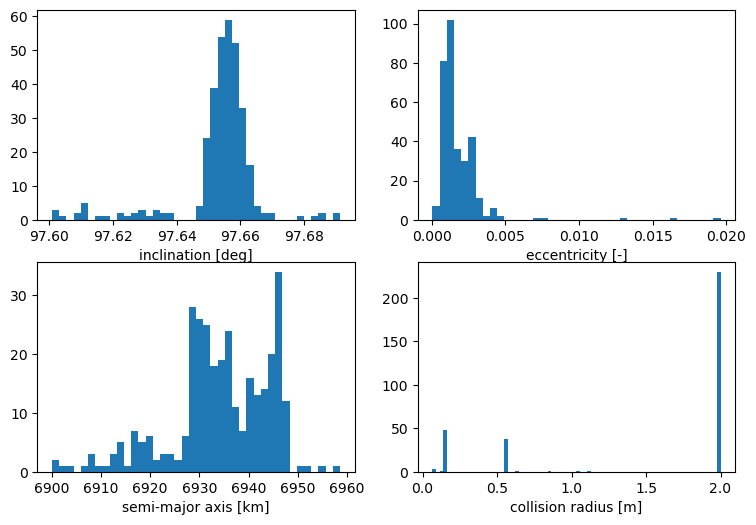

In [114]:
fig, axes = plt.subplots(2,2, figsize = (9,6))
axes[0,0].hist(incl, bins=40);
axes[0,0].set_xlabel("inclination [deg]");

axes[1,0].hist(smal, bins=40);
axes[1,0].set_xlabel("semi-major axis [km]");

axes[0,1].hist(el, bins=40)
axes[0,1].set_xlabel("eccentricity [-]");

axes[1,1].hist(reentry_radiusl, bins=80);
axes[1,1].set_xlabel("collision radius [m]");

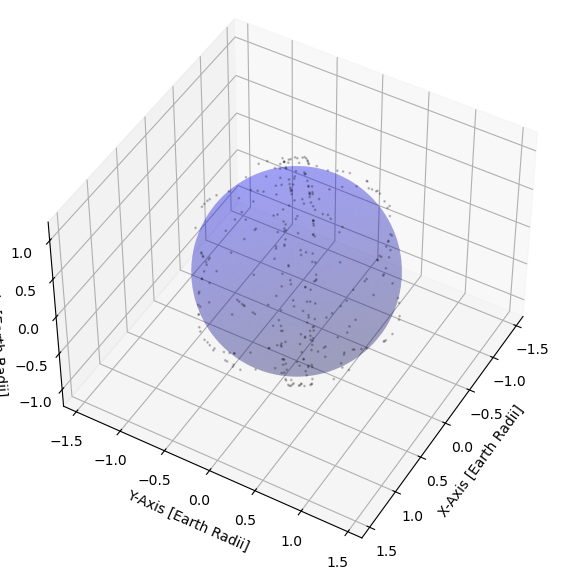

In [115]:
# Create a figure and 3D subplot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
pos = np.array(r)
ax.scatter3D(pos[:, 0] / pk.EARTH_RADIUS, pos[:, 1] / pk.EARTH_RADIUS, pos[:, 2] / pk.EARTH_RADIUS, alpha=0.2, s=1, c='k')
ax.view_init(45,30)

# Set the view
# ax.view_init(45, 30)

# Create a sphere at coordinates (0, 0, 0) with radius equal to Earth's radius
earth_radius = 1
u = np.linspace(0, 2 * np.pi, 100)
vv = np.linspace(0, np.pi, 100)
x = earth_radius * np.outer(np.cos(u), np.sin(vv))
y = earth_radius * np.outer(np.sin(u), np.sin(vv))
z = earth_radius * np.outer(np.ones(np.size(u)), np.cos(vv))

# Plot the sphere
ax.plot_surface(x, y, z, color='b', alpha=0.2)
ax.axis('equal')

# Assign labels to the axes
ax.set_xlabel('X-Axis [Earth Radii]')
ax.set_ylabel('Y-Axis [Earth Radii]')
ax.set_zlabel('Z-Axis [Earth Radii]')

plt.show()


In [116]:
print("Storing the following data (one component displayed for the unit of measure):\nr:",r[1], "\nv:", v[1], "\ncollision radius: ", collision_radiusl[1], to_satcat_index[1], "\n",debris[0])
# with open("data/debris_simulation_ic_GEO.pk", "wb") as file:
#     pkl.dump((r,v,collision_radiusl,to_satcat_index,satcat,debris), file)

Storing the following data (one component displayed for the unit of measure):
r: [-4661023.47487688  1407931.79604295 -4973241.45043008] 
v: [ 5488.27488167  -148.6908119  -5195.63598251] 
collision radius:  0.6274944854015445 7690 
 Planet Name: 1958-002B  
Own gravity parameter: 0.10000000000000001
Central body gravity parameter: 398600800000000
Planet radius: 0.10000000000000001
Planet safe radius: 0.10000000000000001
Ephemerides type: SGP4 propagator
TLE epoch: 2023-Sep-13 02:43:41.366201
TLE 1: 1     5U 58002B   23256.11367322  .00000082  00000-0  81578-4 0  9996
TLE 2: 2     5  34.2576 184.2755 1846644 275.3720  64.0023 10.85083327333804



# We now add the mishap event between the NOAA 7 and the NOAA 12 we created in the notebook

From the notebook, we have thousands of particles. We only have the velocity direction of these particles, so we will take the orbit of the NOAA 7 and we randomize the true anomaly of the particles to spread them along the orbit

In [12]:
with open("breakup.pk", "rb") as file:
    d_vec, v_vec = pkl.load(file)

We define a useful function to help as to transform the Mean anomaly to the Eccentric one (pykep.par2ic requires the Eccentric anomaly, but we have only the Mean)

In [13]:
def Kepler_Solver(M, e):

    # wrapping M
    M_wrap = M % (2 * np.pi)
    k = np.floor(M / (2 * np.pi))  # M = M_wrap + 2k*pi

    # find reduced Eccentric Anomaly using the Kepler's equation
    fun = lambda E: E - e * (np.sin(E)) - M_wrap
    guess = M_wrap + ((e * np.sin(M_wrap)) / (1 - np.sin(M_wrap + e) + np.sin(M_wrap)))
    sol = root(fun, guess)
    E = sol.x  # extracting the root from the solution object

    # computing the reduced true anomaly
    f_wrap = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))

    # unwrapping f_wrap
    f = f_wrap + 2 * k * np.pi

    return E, f

 This is a crucial part of the code. First of all, we define the orbit of the NOAA-7 vector (from https://www.heavens-above.com/orbit.aspx?satid=12553) at 30th November, 2023. Then, we generate 4 breakup event and we propagate them forward in time by randomizing the Eccentric anomaly and the RAAN (J2 effect on the orbit). Finally, to have a lot of collisions, we increase the collision radius of the particle by a factor 10.

In [14]:
a_NOAA7 = ((pk.EARTH_RADIUS + (825*1000)) + (pk.EARTH_RADIUS + (843*1000)))/2 # [m]
e_NOAA7 = 0.0012401
i_NOAA7 = np.deg2rad(98.9262)
OM_NOAA7 = np.deg2rad(20.5565)
om_NOAA7 = np.deg2rad(68.5334)
M_NOAA7 = np.deg2rad(291.7161)
E_NOAA7, f = Kepler_Solver(M_NOAA7, e_NOAA7)

import random
# finding the cartesian parameter of the orbit with pykep and randomizing it
# then we update teh satcat
for i in range(len(v_vec)):
    r_NOAA7, v_NOAA7 = pk.par2ic([a_NOAA7, e_NOAA7, i_NOAA7, OM_NOAA7 + random.uniform(0, 2 * np.pi), om_NOAA7, E_NOAA7[0] + random.uniform(0, 2 * np.pi)], pk.MU_EARTH)
    # we update the r, v and collision_radius vectors
    r = np.vstack((r, r_NOAA7))
    v = np.vstack((v, [v_NOAA7[0] + v_vec[i][0], v_NOAA7[1] + v_vec[i][1], v_NOAA7[2] + v_vec[i][2]])) 
    collision_radiusl = np.hstack((collision_radiusl, d_vec[i]*10))
    # since from the satcat we will take only bstar, here we will copy a random particle inside our catalogue to update it
    satcat.append(satcat[np.random.randint(0, len(to_satcat_index))])
    to_satcat_index = np.hstack((to_satcat_index, (len(satcat) - 1)))
    
for i in range(len(v_vec)):
    r_NOAA7, v_NOAA7 = pk.par2ic([a_NOAA7, e_NOAA7, i_NOAA7, OM_NOAA7 + random.uniform(0, 2 * np.pi), om_NOAA7, E_NOAA7[0] + random.uniform(0, 2 * np.pi)], pk.MU_EARTH)
    # we update the r, v and collision_radius vectors
    r = np.vstack((r, r_NOAA7))
    v = np.vstack((v, [v_NOAA7[0] + v_vec[i][0], v_NOAA7[1] + v_vec[i][1], v_NOAA7[2] + v_vec[i][2]])) 
    collision_radiusl = np.hstack((collision_radiusl, d_vec[i]*10))
    # since from the satcat we will take only bstar, here we will copy a random particle inside our catalogue to update it
    satcat.append(satcat[np.random.randint(0, len(to_satcat_index))])
    to_satcat_index = np.hstack((to_satcat_index, (len(satcat) - 1)))

for i in range(len(v_vec)):
    r_NOAA7, v_NOAA7 = pk.par2ic([a_NOAA7, e_NOAA7, i_NOAA7, OM_NOAA7 + random.uniform(0, 2 * np.pi), om_NOAA7, E_NOAA7[0] + random.uniform(0, 2 * np.pi)], pk.MU_EARTH)
    # we update the r, v and collision_radius vectors
    r = np.vstack((r, r_NOAA7))
    v = np.vstack((v, [v_NOAA7[0] + v_vec[i][0], v_NOAA7[1] + v_vec[i][1], v_NOAA7[2] + v_vec[i][2]])) 
    collision_radiusl = np.hstack((collision_radiusl, d_vec[i]*10))
    # since from the satcat we will take only bstar, here we will copy a random particle inside our catalogue to update it
    satcat.append(satcat[np.random.randint(0, len(to_satcat_index))])
    to_satcat_index = np.hstack((to_satcat_index, (len(satcat) - 1)))

for i in range(len(v_vec)):
    r_NOAA7, v_NOAA7 = pk.par2ic([a_NOAA7, e_NOAA7, i_NOAA7, OM_NOAA7 + random.uniform(0, 2 * np.pi), om_NOAA7, E_NOAA7[0] + random.uniform(0, 2 * np.pi)], pk.MU_EARTH)
    # we update the r, v and collision_radius vectors
    r = np.vstack((r, r_NOAA7))
    v = np.vstack((v, [v_NOAA7[0] + v_vec[i][0], v_NOAA7[1] + v_vec[i][1], v_NOAA7[2] + v_vec[i][2]])) 
    collision_radiusl = np.hstack((collision_radiusl, d_vec[i]*10))
    # since from the satcat we will take only bstar, here we will copy a random particle inside our catalogue to update it
    satcat.append(satcat[np.random.randint(0, len(to_satcat_index))])
    to_satcat_index = np.hstack((to_satcat_index, (len(satcat) - 1)))

# We plot some plots

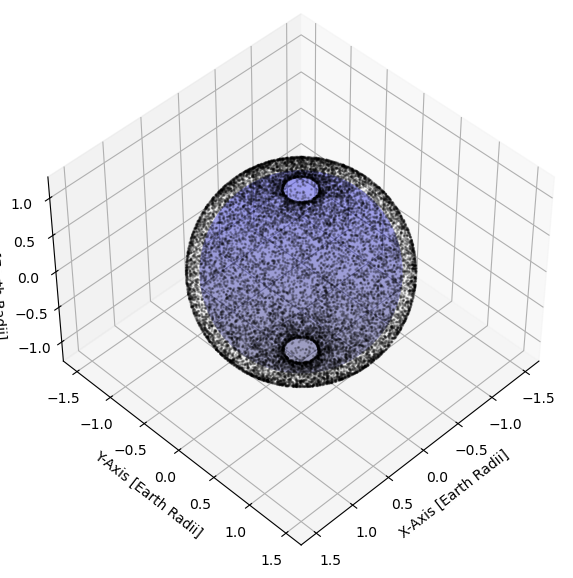

In [17]:
# Create a figure and 3D subplot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
pos = np.array(r)
# we sligthly randomize the position to have a better visualization of the breakup event
ax.scatter3D((pos[:, 0]) / pk.EARTH_RADIUS, (pos[:, 1]) / pk.EARTH_RADIUS, (pos[:, 2]) / pk.EARTH_RADIUS, alpha=0.2, s=1, c='k')
ax.view_init(45, 45)

# Create a sphere at coordinates (0, 0, 0) with radius equal to Earth's radius
earth_radius = 1
u = np.linspace(0, 2 * np.pi, 100)
vv = np.linspace(0, np.pi, 100)
x = earth_radius * np.outer(np.cos(u), np.sin(vv))
y = earth_radius * np.outer(np.sin(u), np.sin(vv))
z = earth_radius * np.outer(np.ones(np.size(u)), np.cos(vv))

# Plot the sphere
ax.plot_surface(x, y, z, color='b', alpha=0.2)
ax.axis('equal')

# Assign labels to the axes
ax.set_xlabel('X-Axis [Earth Radii]')
ax.set_ylabel('Y-Axis [Earth Radii]')
ax.set_zlabel('Z-Axis [Earth Radii]')

# Save the plot in high quality
fig.savefig('IC_SSO_breakup.png', dpi=800)

plt.show()

In [125]:
# print("Storing the following data (one component displayed for the unit of measure):\nr:",r[1], "\nv:", v[1], "\ncollision radius: ", collision_radiusl[1], to_satcat_index[1], "\n",debris[0])
# with open("data/debris_simulation_ic_SSO_breakup.pk", "wb") as file:
#     pkl.dump((r,v,collision_radiusl,to_satcat_index,satcat,debris), file)

Storing the following data (one component displayed for the unit of measure):
r: [-4661023.47487688  1407931.79604295 -4973241.45043008] 
v: [ 5488.27488167  -148.6908119  -5195.63598251] 
collision radius:  0.6274944854015445 7690 
 Planet Name: 1958-002B  
Own gravity parameter: 0.10000000000000001
Central body gravity parameter: 398600800000000
Planet radius: 0.10000000000000001
Planet safe radius: 0.10000000000000001
Ephemerides type: SGP4 propagator
TLE epoch: 2023-Sep-13 02:43:41.366201
TLE 1: 1     5U 58002B   23256.11367322  .00000082  00000-0  81578-4 0  9996
TLE 2: 2     5  34.2576 184.2755 1846644 275.3720  64.0023 10.85083327333804

